Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [8]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt

In [62]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
y = t[2].values

In [59]:
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [32]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [61]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
len(singles)

80

In [86]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = [wt] + singles
train_inds = [seq_to_x[seq] for seq in train_seqs]
train_inds += list(np.random.choice(len(X), 100, replace=True)) # generate random indices for 100 X's to sample from

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

In [66]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [29]:
def seqs_from_set(chosen, L):
    pos = [[c[0] for c in chosen if c[1] == p] for p in range(L)]
    return [''.join(s) for s in itertools.product(*pos)]

seqs = seqs_from_set(chosen, 4)
X_sampled = [X_train]
y_sampled = [y_train]

In [88]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100


observed_inds = [train_inds]
X_sampled = [X[train_inds]]
y_sampled = [y[train_inds]]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    dic, _ = helpers.get_predictions(X[inds], y[inds], X_test, its=500)    
    print()
    best_loss = 0.0
    best_X = None
    best_h = None
    for i in range(max_its):
        np.random.seed(i)
        center = np.random.choice(len(ground), n_start, replace=False)
        center = [ground[c] for c in center]
        chosen, h = opt.mod_mod(ground, opt.obj_LHS, opt.obj_RHS, center, 
                           fn_args=(L, dic), g_args=(L, dic, n), verbose=False)
        if h[-1] < best_loss:
            best_loss = h[-1]
            best_X = chosen
            best_h = h
    libraries.append(best_X)
    histories.append(best_h)
    seqs = seqs_from_set(best_X, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(X[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    

Round 0
Iteration 500 of 500	NLML: 37.8196	sn: 0.176778	
Round 1
Iteration 500 of 500	NLML: 21.9836	sn: 0.487011	
Round 2
Iteration 500 of 500	NLML: 16.5508	sn: 0.478253	
Round 3
Iteration 500 of 500	NLML: 6.2960	sn: 0.471376		


In [77]:
libraries

[[('I', 0),
  ('S', 0),
  ('D', 0),
  ('L', 0),
  ('Q', 0),
  ('L', 1),
  ('D', 1),
  ('W', 1),
  ('Q', 1),
  ('H', 1),
  ('K', 1),
  ('S', 1),
  ('S', 2),
  ('C', 2),
  ('Q', 2),
  ('E', 3),
  ('D', 3),
  ('S', 3),
  ('L', 3),
  ('W', 3)],
 [('S', 0),
  ('H', 0),
  ('C', 1),
  ('I', 1),
  ('D', 1),
  ('W', 1),
  ('Q', 1),
  ('K', 1),
  ('S', 1),
  ('S', 2),
  ('E', 3),
  ('S', 3),
  ('L', 3),
  ('V', 3),
  ('M', 3),
  ('W', 3)],
 [('S', 0),
  ('F', 1),
  ('K', 1),
  ('S', 1),
  ('T', 1),
  ('S', 2),
  ('I', 2),
  ('T', 2),
  ('S', 3),
  ('E', 3),
  ('G', 3),
  ('K', 3),
  ('I', 3),
  ('H', 3),
  ('C', 3),
  ('T', 3)]]

In [78]:
histories

[[tensor(-3.7870),
  tensor(-4.2109),
  tensor(-4.4620),
  tensor(-4.4620),
  tensor(-4.5792),
  tensor(-4.5792),
  tensor(-4.6616),
  tensor(-4.6616),
  tensor(-4.8239),
  tensor(-4.8300),
  tensor(-4.8300),
  tensor(-4.8691),
  tensor(-5.0164),
  tensor(-5.0164),
  tensor(-5.0164),
  tensor(-5.0164),
  tensor(-5.0164),
  tensor(-5.2042),
  tensor(-5.2043),
  tensor(-5.7127),
  tensor(-5.7127),
  tensor(-5.7127),
  tensor(-6.3421),
  tensor(-6.8758),
  tensor(-7.7313),
  tensor(-7.7313)],
 [tensor(-1.1298),
  tensor(-1.9876),
  tensor(-3.3362),
  tensor(-4.3455),
  tensor(-5.7700),
  tensor(-5.7700),
  tensor(-6.1931),
  tensor(-12.0296),
  tensor(-12.0296)],
 [tensor(-2.7170),
  tensor(-3.5798),
  tensor(-3.5798),
  tensor(-5.0811),
  tensor(-5.3406),
  tensor(-5.4788),
  tensor(-6.0079),
  tensor(-6.1019),
  tensor(-6.3645),
  tensor(-9.6081),
  tensor(-10.8951),
  tensor(-11.2054),
  tensor(-11.2054)]]

In [91]:
df = pd.DataFrame(np.concatenate(y_sampled), columns=['y'])
df['round'] = [0] * (81 + n) + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,-2.982025,0
1,-2.982025,0
2,-5.000000,0
3,-3.216056,0
4,-5.000000,0


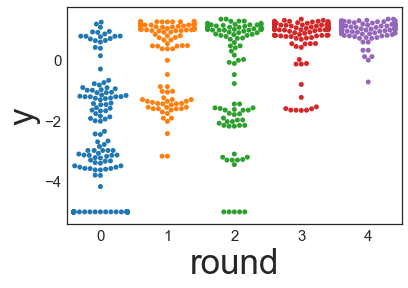

In [92]:
_ = sns.swarmplot(data=df, x='round', y='y')

In [93]:
[max(yy) for yy in y_sampled]

[1.2350148061910993,
 1.2641211135597676,
 1.334396682952795,
 1.334396682952795,
 1.3343422566796406]

In [94]:
[opt.get_N(lib, L) for lib in libraries]

[120, 210, 144, 120]